# Sugarcane ethanol biorefinery

In case study, we will evaluate the potential economic feasibility of a sugarcane-to-ethanol biorefinery and characterize the major assumptions driving economics. We begin by building a complete biorefinery from scratch and later show how BioSTEAM ProcessModel objects and published BioSTEAM models can facilitate biorefinery creation. The sugarcane-to-ethanol biorefinery is designed according to [[1]](#References), including all process setings, prices, and assumptions.

## Thermodynamic property package

First create the thermodynamic property package to define the chemicals in the process. We can follow the [example](https://thermosteam.readthedocs.io/en/latest/tutorial/Thermo_property_packages.html) in Thermosteam's docs to do this:

In [1]:
import biosteam as bst
bst.nbtutorial() # Ignore warnings and reset local BioSTEAM preferences
bst.settings.set_thermo(
    ['Water', # Define chemicals by name
     'Ethanol',
     'Octane',
     'Glucose',
     'Sucrose',
     'H3PO4',
     'P4O10',
     'CO2',
     'O2', 
     'N2', 
     'CH4',
     'Cellulose',
     'Hemicellulose',
     'Lignin',
     'Flocculant',
     'Solids',
     'DryYeast',
     'CaO',
     'Ash'], 
    # Use the BioSTEAM database (not the default ChEDL) for common 
    # biorefinery chemicals like lignocellulosic components.
    db='BioSTEAM'
)
# Loading Cellulose from the BioSTEAM database is approximately
# equal to the following code:
# bst.Chemical(
#     'Cellulose',
#     Cp=1.364, # Heat capacity [kJ/kg]
#     rho=1540, # Density [kg/m3]
#     default=True, # Default other chemicals properties like viscosity to that of water at 25 C
#     search_db=False, # Not in database, so do not search the database
#     phase='s', 
#     formula="C6H10O5", # Glucose monomer minus water, molecular weight is computed based on formula
#     Hf=-975708.8 # Heat of formation [J/mol]
# ) 

## Process settings

Before any simulations, we define the conditions of all our utilities and the Chemical Engineering Plant Cost Indes (CEPCI):

In [2]:
bst.settings.CEPCI = 567 # CEPCI: 2013
bst.settings.electricity_price = 0.065
# Steam is produced on-site by a boiler,
# so make it the only available heating agent.
steam_utility = bst.settings.get_agent('low_pressure_steam')
bst.settings.heating_agents = [steam_utility]
steam_utility.heat_transfer_efficiency = 0.9
steam_utility.T = 529.2
steam_utility.P = 44e5

# Steam, cooling water, and chilled water are regenerated by
# on-site facilities. The regeneration and heat transfer
# prices are given accounted for by the capital cost and
# electricity consumption of these facilities
steam_utility.regeneration_price = 0.
bst.settings.get_agent('cooling_water').regeneration_price = 0
bst.settings.get_agent('chilled_water').heat_transfer_price = 0

# Raw material price (USD/kg)
price = {'Sugar cane': 0.03455, # 70% m.c
         'Water': 0.000353,
         'HCl': 0.205,
         'Lime': 0.077,
         'H3PO4': 0, # Not significant
         'NaOH':0.41,
         'Protease': 0.5,
         'Polymer': 0, # Not significant
         'Steam': 0.017,
         'Ethanol': 0.789,
         'Waste': -0.33,
         'Gasoline': 0.756} # 2 USD/gal

## Unit operations and simulation

First define the unit operations for feedstock handling (area 100) and juicing (area 200):

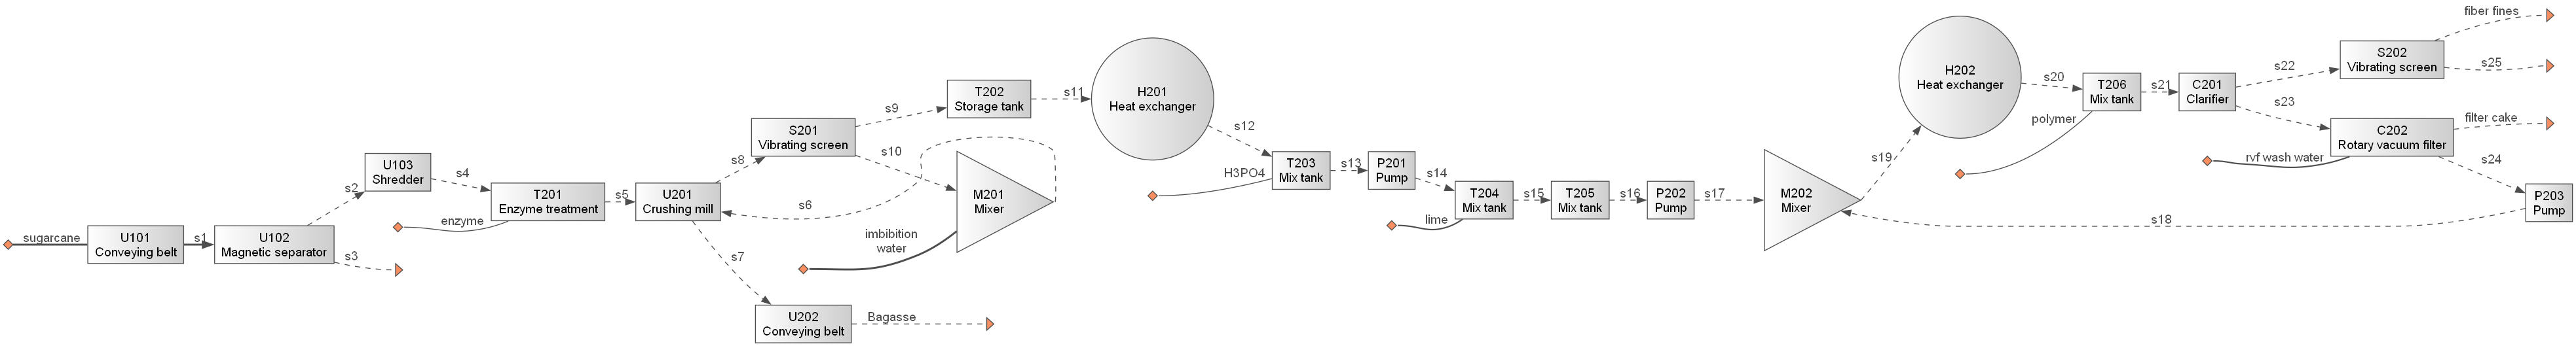

In [3]:
from biosteam import units
import numpy as np

bst.main_flowsheet.set_flowsheet('sugarcane_ethanol')

# We can create streams and set component splits faster by defining chemical groups
chemicals = bst.settings.chemicals
chemicals.define_group(
    name='Fiber',
    IDs=['Cellulose', 'Hemicellulose', 'Lignin'],
    composition=[0.4704 , 0.2775, 0.2520],
    wt=True, # Composition is given as weight
)
chemicals.define_group(
    name='Sugar',
    IDs=['Sucrose', 'Glucose'],
    # Default composition as equimolar
)

sugarcane = bst.Stream(
    'sugarcane',
    Water=0.7,
    Glucose=0.01208,
    Sucrose=0.1369,
    Ash=0.006,
    Fiber=0.13,
    Solids=0.015,
    total_flow=370396,
    units='kg/hr',
    price=price['Sugar cane']
)

enzyme = bst.Stream('enzyme',
                    Cellulose=100, Water=900, units='kg/hr',
                    price=price['Protease'])

imbibition_water = bst.Stream('imbibition_water',
                              Water=87023.35, units='kg/hr',
                              T = 338.15)

H3PO4 = bst.Stream('H3PO4',
                   H3PO4=74.23, Water=13.10, units='kg/hr',
                   price=price['H3PO4'])  # to T203

lime = bst.Stream('lime',
                  CaO=333.00, Water=2200.00, units='kg/hr',
                  price=price['Lime'])  # to P5

polymer = bst.Stream('polymer',
                     Flocculant=0.83, units='kg/hr',
                     price=price['Polymer'])  # to T205

rvf_wash_water = bst.Stream('rvf_wash_water',
                            Water=16770, units='kg/hr',
                            T=363.15)  # to C202

### Unit operations ###

# Feed from storage
U101 = units.ConveyingBelt('U101', sugarcane)

# Separate metals
U102 = units.MagneticSeparator('U102', U101-0)

# Shredded cane
U103 = units.Shredder('U103', U102-0)

# Hydrolyze starch
T201 = units.EnzymeTreatment('T201', [U103-0, enzyme], T=323.15)  # T=50

# Finely crush lipid cane
imbibition_water_recycle = bst.Stream() # To connect later
U201 = units.CrushingMill('U201', [T201-0, imbibition_water_recycle],
                          split=dict(Ash=0.92,
                                     Fiber=0.92,
                                     Sugar=0.04,
                                     Solids=1),
                          moisture_content=0.5)

# Convey out bagasse
U202 = units.ConveyingBelt('U202', U201-0, outs='Bagasse')

# Screen out fibers
S201 = units.VibratingScreen('S201', U201-1,
                             split=dict(Ash=0.35,
                                        Fiber=0.35,
                                        Sugar=0.88,
                                        Water=0.88,
                                        Solids=0))

# Mix in water
M201 = units.Mixer('M201', [S201-1, imbibition_water], imbibition_water_recycle)

# Store juice before treatment
T202 = units.StorageTank('T202', S201-0, tau=4, vessel_material='Carbon steel')

# Heat up before adding acid
H201 = units.HXutility('H201', T202-0, T=343.15)

# Mix in acid
T203 = units.MixTank('T203', [H201-0, H3PO4])

# Pump acid solution
P201 = units.Pump('P201', T203-0)

# Mix lime solution
T204 = units.MixTank('T204', [P201-0, lime], tau=0.10)

# Blend acid lipid solution with lime
T205 = units.MixTank('T205', T204-0, tau=0.10)
P202 = units.Pump('P202', T205-0)

# Mix recycle
RVF_recycle = bst.Stream() # From rotary vacuum filter; connect later
M202 = units.Mixer('M202', [P202-0, RVF_recycle])

# Heat before adding flocculant
H202 = units.HXutility('H202', M202-0, T=372.15)

# Mix in flocculant
T206 = units.MixTank('T206', [H202-0, polymer])
T206.tau = 0.10

# Separate residual solids
C201 = units.Clarifier('C201', T206-0,
                       split=dict(Ash=0,
                                  CaO=0,
                                  Fiber=0,
                                  Flocculant=0.522,
                                  Sugar=0.522,
                                  H3PO4=0.522,
                                  Water=0.522))

# Remove solids as filter cake
C202 = units.RVF('C202', [C201-1, rvf_wash_water],
                 outs=('filter_cake', ''),
                 moisture_content=0.80,
                 split=dict(Ash=0.85,
                            CaO=0.85,
                            Fiber=0.85,
                            Sugar=0.01))
P203 = units.Pump('P203', C202-1, RVF_recycle)


# Screen out small fibers from sugar stream
S202 = units.VibratingScreen('S202', C201-0,
                             outs=('', 'fiber_fines'),
                             split=dict(Ash=1.0,
                                        CaO=1.0,
                                        Fiber=1.0,
                                        Flocculant=0.0,
                                        Sugar=0.998,
                                        H3PO4=1.0,
                                        Water=0.998))
S202.mesh_opening = 2

### Process specifications ###

# Specifications dependent on lipid cane flow rate
@U103.add_specification(run=True) # Run unit operation afterwords
def correct_flows():
    feedstock = U101.ins[0]
    F_mass = feedstock.F_mass
    # correct enzyme, lime, phosphoric acid, and imbibition water
    enzyme.imass['Cellulose', 'Water'] = 0.003 * F_mass * np.array([0.1, 0.9])
    lime.imass['CaO', 'Water'] = 0.001 * F_mass * np.array([0.046, 0.954])
    H3PO4.imass['H3PO4', 'Water'] = 0.00025 * F_mass
    imbibition_water.imass['Water'] = 0.25* F_mass

# Specifications within a system
@P202.add_specification(run=True)
def correct_wash_water():
    solids = P202.ins[0].imol['Ash', 'CaO', 'Fiber'].sum()
    rvf_wash_water.imol['Water'] = 0.0574 * solids

bst.main_flowsheet.diagram(format='png') # Flow sheet up until now

Define unit operations for ethanol production from juice (area 300):

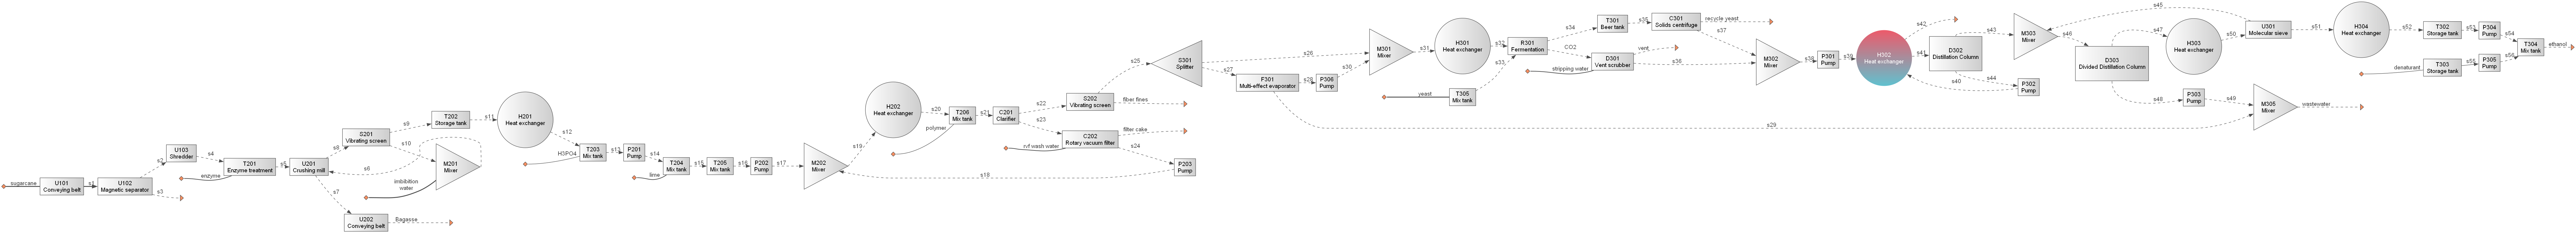

In [4]:
### Streams ###
    
# Fresh water
stripping_water = bst.Stream('stripping_water', Water=5000, units='kg/hr')

# Gasoline
denaturant = bst.Stream('denaturant', Octane=230.69,
                        units='kg/hr', price=price['Gasoline'])

# Yeast
yeast = bst.Stream('yeast', Water=24700, DryYeast=10300, units='kg/hr')

# Ethanol product
ethanol = bst.Stream('ethanol', price=price['Ethanol'])

### Units ###

# Split sugar solution
S301 = units.Splitter('S301',  S202-0, split=0.10)

# Concentrate sugars
F301 = units.MultiEffectEvaporator('F301', S301-1,
                                   P=(101325, 73581, 50892, 32777),
                                   V_definition='First-effect',
                                   V=0.1) # fraction evaporated
P306 = units.Pump('P306', F301-0)

# Mix sugar solutions
M301 = units.Mixer('M301', [P306-0, S301-0])

F301.target_sugar_concentration = 0.23 # wt. % sugar
@F301.add_bounded_numerical_specification(x0=0, x1=1, xtol=1e-5, ytol=1e-2)
def sugar_concentration_at_fraction_evaporated(V):
    F301.V = V
    F301.run_until(M301, inclusive=True) # Run all units starting from F301 to M301 
    sugar_concentration = M301.outs[0].get_mass_fraction('Sugar')
    return F301.target_sugar_concentration - sugar_concentration

# Cool for fermentation
H301 = units.HXutility('H301', M301-0, T=295.15)

# Yeast preparation
T305 = units.MixTank('T305', yeast)
T305.tau = 0.1

# Ethanol Production
R301 = units.Fermentation('R301', [H301-0, T305-0], outs=('CO2', ''), tau=9, efficiency=0.90, N=4) 
R301.cell_growth_reaction.X = 0. # Ignore for simplicity
T301 = units.StorageTank('T301', R301-1, tau=4, vessel_material='Carbon steel')
T301.line = 'Beer tank' # Changes name on the diagram

D301 = units.VentScrubber('D301', ins=(stripping_water, R301-0), 
                          outs=('vent', ''),
                          gas=('CO2',))

# Separate 99% of yeast
C301 = units.SolidsCentrifuge('C301', T301-0, outs=('recycle_yeast', ''),
                            moisture_content=0.5,
                            split=(1, 0.99999, 0.99), # This gets reverted in the next line
                            order=('Ethanol', 'Glucose',  'DryYeast'),
                            solids=('DryYeast',))
C301.split[:] = 1. - C301.split

# Add bottoms from scrubber
M302 = units.Mixer('M302', [C301-1, D301-1])
P301 = units.Pump('P301', M302-0)

# Heat up before beer column
# Exchange heat with stillage
bottoms_product = bst.Stream() # Bottoms product from beer column, connect later
H302 = units.HXprocess('H302', [P301-0, bottoms_product], U=1.28)

# Beer column
D302 = units.BinaryDistillation(
    'D302', H302-0, P=2.1 * 101325,
    Lr=0.99993, Hr=0.8735, # Light and heavy key recoveries
    LHK=('Ethanol', 'Water'), # Light and heavy key
    k=1.1, # Ratio of actual reflux over minimum reflux 
    Rmin=0.001, # Minimum allowable reflux ratio
) 
D302.tray_material = 'Stainless steel 304'
D302.vessel_material = 'Stainless steel 304'
D302.reboiler.U = 1.85
P302 = units.Pump('P302', D302-1, bottoms_product)

# Mix ethanol Recycle (Set-up)
molecular_sieve_recycle = bst.Stream()
M303 = units.Mixer('M303', [D302-0, molecular_sieve_recycle])

D303 = units.BinaryDistillation(
    'D303', M303-0, 
    P=10 * 101325, # Higher pressure to enable heat exchanger between condenser and multi-effect evaporator
    y_top=0.80805, x_bot=3.91e-06,  # Molar fraction of light key in the distillate and bottoms product
    k=1.15,
    LHK=('Ethanol', 'Water'),
    tray_material='Stainless steel 304',
    vessel_material='Stainless steel 304',
    is_divided=True
)
D303.reboiler.U = 1.85
P303 = units.Pump('P303', D303-1)

# Superheat vapor for mol sieve
H303 = units.HXutility('H303', D303-0, T=115+273.15, V=1, heat_only=True)

# Molecular sieve
U301 = units.MolecularSieve('U301', H303-0, [molecular_sieve_recycle, ''],
                            split=dict(Ethanol=0.1621,
                                       Water=0.925))

# Condense ethanol product
H304 = units.HXutility('H304', U301-1, V=0, T=340.)
T302 = units.StorageTank('T302', H304-0, tau=7*24, # 1 week storage capacity
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P304 = units.Pump('P304', T302-0)

# Storage for denaturant
T303 = units.StorageTank('T303', denaturant, tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P305 = units.Pump('P305', T303-0)

# Denatured ethanol product
T304 = units.MixTank('T304', [P305-0, P304-0], outs=ethanol)
T304.tau = 0.10 # 6 min residence time

# Waste water
M305 = units.Mixer('M305', [P303-0, F301-1], outs='wastewater')

@P304.add_specification(run=True)
def adjust_denaturant():
    pure_ethanol = P304.ins[0]
    denaturant.imol['Octane'] = 0.021*pure_ethanol.F_mass/114.232

bst.main_flowsheet.diagram('thorough', format='png') # Flowsheet up until now

Define facilities which use data from unit operations to solve for utility requirements:

In [5]:
s = bst.main_flowsheet.stream
BT = bst.BoilerTurbogenerator('BT',
    (U202-0, '', 'boiler_makeup_water', 'natural_gas', '', ''),
    boiler_efficiency=0.80, turbogenerator_efficiency=0.85
)
CT = bst.CoolingTower('CT')
makeup_water = bst.Stream('makeup_water', price=0.000254)
CWP = bst.ChilledWaterPackage('CWP')
PWC = bst.ProcessWaterCenter('PWC',
    ins=(bst.Stream(), makeup_water, P303-0), outs=(),
    makeup_water_streams=(s.cooling_tower_makeup_water, s.boiler_makeup_water),
    process_water_streams=(imbibition_water, rvf_wash_water, stripping_water, 
                           s.cooling_tower_makeup_water, s.boiler_makeup_water)
)
HXN = bst.HeatExchangerNetwork('HXN', units=[F301, D303.condenser])

Create the system and simulate:

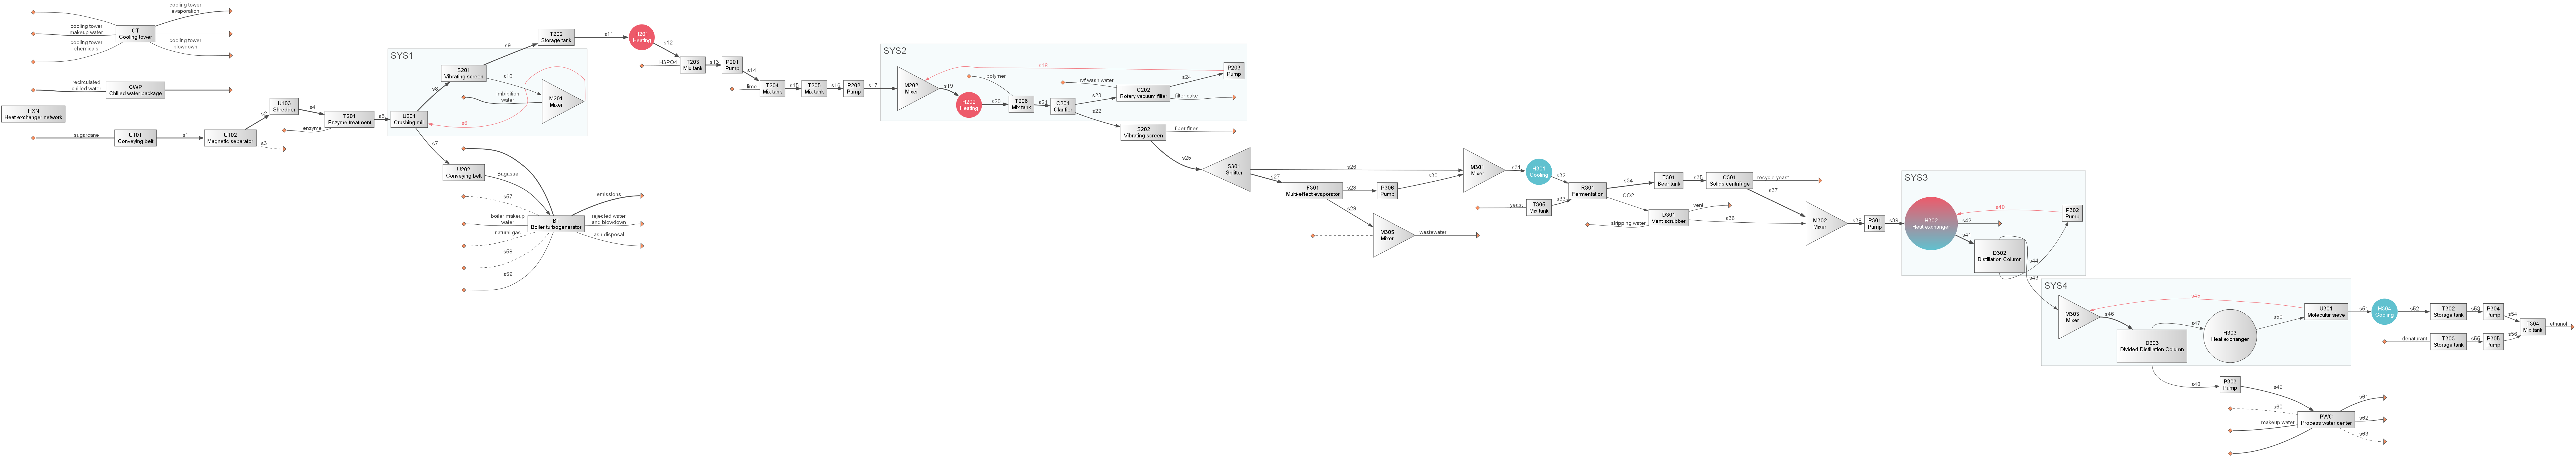

System('sugarcane_sys',
    [U101,
     U102,
     U103,
     T201,
     System('SYS1',
        [U201,
         S201,
         M201],
        recycle=M201-0),
     T202,
     H201,
     T203,
     P201,
     T204,
     T205,
     P202,
     System('SYS2',
        [M202,
         H202,
         T206,
         C201,
         C202,
         P203],
        recycle=P203-0),
     S202,
     S301,
     F301,
     P306,
     M301,
     H301,
     T305,
     R301,
     T301,
     C301,
     D301,
     M302,
     P301,
     System('SYS3',
        [H302,
         D302,
         P302],
        recycle=P302-0),
     System('SYS4',
        [M303,
         D303,
         H303,
         U301],
        recycle=U301-0),
     H304,
     T302,
     P304,
     T303,
     P305,
     T304,
     P303,
     M305,
     U202],
    facilities=[HXN,
     CWP,
     CT,
     BT,
     PWC])


In [6]:
sugarcane_sys = bst.main_flowsheet.create_system('sugarcane_sys')
sugarcane_sys.simulate()
sugarcane_sys.diagram('cluster', format='png') # Red streams are recycles (i.e. tear streams)
sugarcane_sys.print() # Show system simulation order

Note that BioSTEAM generates nested systems to solve recycle streams robustly.

## Biorefinery characterization

Let's divide the biorefinery by area (i.e., feedstock handling, juicing, ethanol production) and plot key results to understand how each area contributes to capital and operating expenditures. We can use BioSTEAM's UnitGroup objects to group the unit operations by area:

In [7]:
UnitGroup = bst.process_tools.UnitGroup
unit_groups = UnitGroup.group_by_area(sugarcane_sys.units)
# The code above returns the following by grouping units by "area" number
# unit_groups = [
#     UnitGroup('Feedstock handling', [U101, U102, U103]),
#     UnitGroup('Juicing', 
#         [T201, U201, S201, M201, T202, H201, T203, P201, T204,
#         T205, P202, M202, H202, T206, C201, C202, P203, S202]
#     ),
#     UnitGroup('Ethanol production',
#         [S301, F301, P306, M301, H301, T305, R301, T301, C301, 
#          M302, P301, H302, D302, P302, M303, D303, H303, U301, 
#          H304, T302, P304, T303, P305, T304, D301, P303, M305]
#     ),
#     UnitGroup('Facilities', sugarcane_sys.facilities)
# ]

# Add key metrics and use short names (like elec. cons. for electricty consumption).
for group in unit_groups: group.autofill_metrics(shorthand=True)

area_names = {'0': 'Facilities',
              '100': 'Feedstock handling',
              '200': 'Juicing',
              '300': 'Ethanol production'}
for i in unit_groups: i.name = area_names[i.name]
UnitGroup.df_from_groups(unit_groups)

,Inst. eq. cost [MM$],Cooling [GJ/hr],Heating [GJ/hr],Elec. cons. [MW],Mat. cost [USD/hr]
Facilities,85.2,108,0,4.52,12.9
Feedstock handling,5.39,0,0,2.23,1.28e+04
Juicing,16.7,0,553,2.67,584
Ethanol production,18.2,236,228,0.695,402


Now we can generate a breakdown of results by biorefinery from the unit groups.

(<Figure size 1280x960 with 3 Axes>,
 array([<Axes: ylabel='Cost and Utility Breakdown [%]'>], dtype=object))

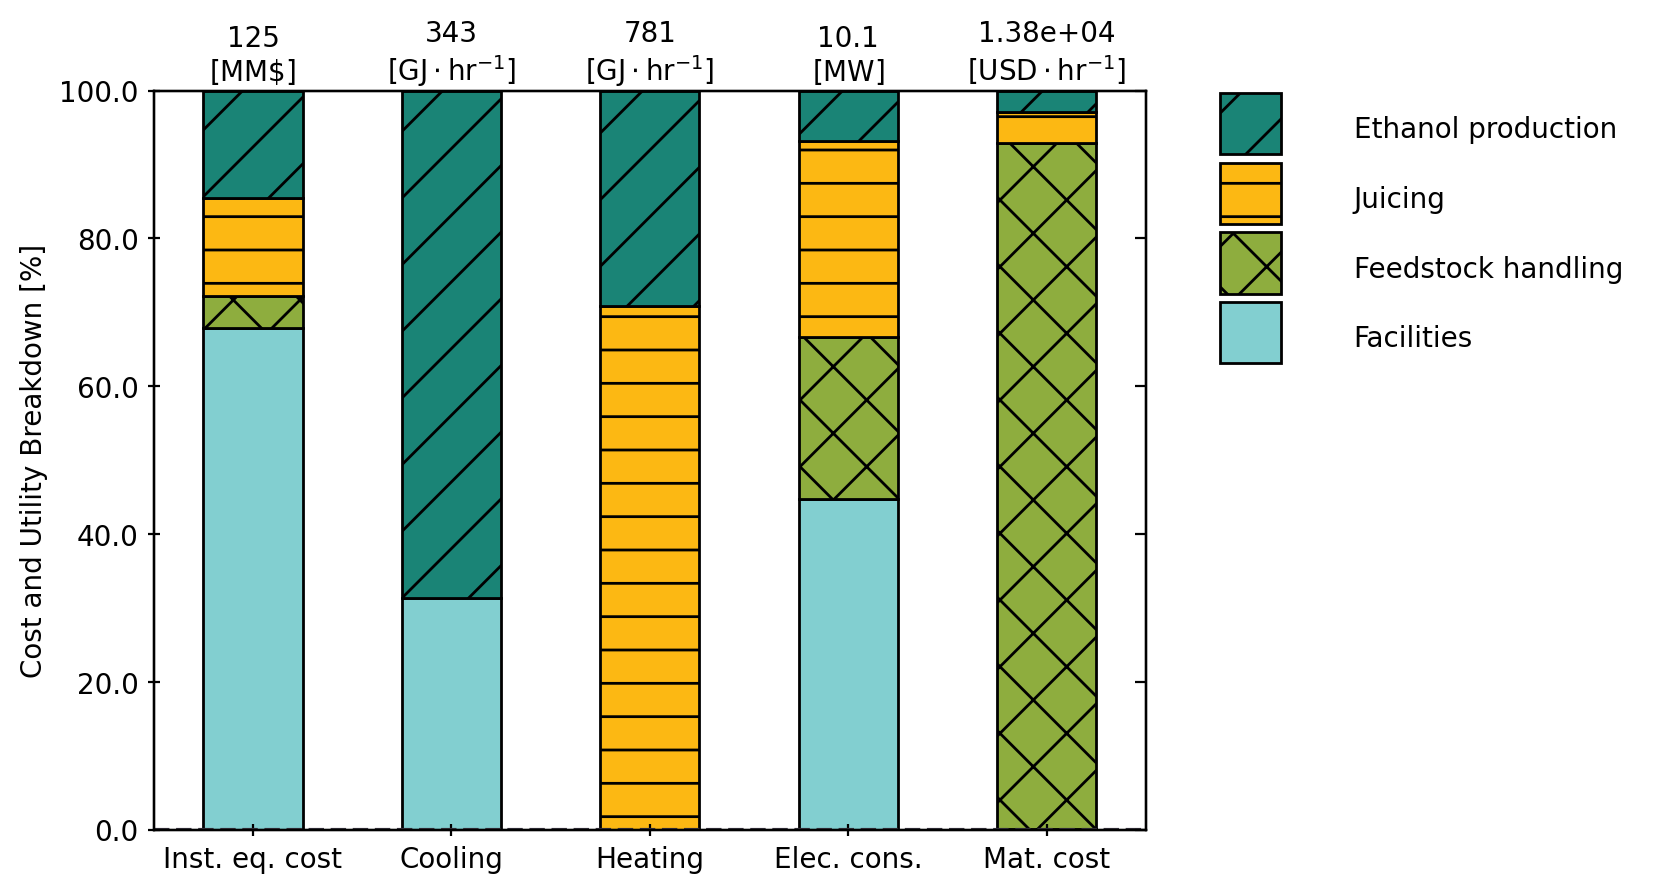

In [8]:
# For convinience, BioSTEAM has plotting methods centered on UnitGroup objects
bst.plots.plot_unit_groups(unit_groups, fraction=True)

From the table and plot, we can see that the ethanol production contributes a large fraction of the total cooling and heating demand. This is expected from the cooling and heating required operation of the fermentation bioreactors and the distillation columns.

## Techno-Economic Analysis (TEA)

Here we use the default TEA setup used in [[1]](#Reference) to solve for the internal rate of return (IRR) at a net pressent value (NPV) of 0:

In [9]:
import biorefineries.sugarcane as sc 
sugarcane_tea = sc.create_tea(sugarcane_sys)
sugarcane_tea.solve_IRR() 

0.1279571270962684

We can also find the minimum ethanol selling price (to breakeven at an NPV of 0) given the IRR:

In [10]:
sugarcane_tea.IRR = 0.10
ethanol_price = sugarcane_tea.solve_price(ethanol) # USD/kg
ethanol_price * 2.98668849 # to USD/gal

2.1814521469702863

Or even the maximum feedstock purchase price (to breakeven at an NPV of 0):

In [11]:
sugarcane_tea.solve_price(sugarcane)

0.038645464343432245

This result may be slightly off from the  referenced study [[1]](#Refernces) due to some simplifications on yeast production. A more rigorous model is available in `biorefineries.sugarcane`. For additional details on TEA, checkout the [chapter on TEA](./Techno-economic_analysis.ipynb) 

## Sensitivity analysis

Let's evaluate the sensitivity around the feedstock price, processing capacity, and fermentation efficiency. We can use a [Model](../API/evaluation/Model.txt) object to define input parameters and output metrics and perform a single-point sensitivity analysis.

(<Figure size 1280x960 with 3 Axes>, <Axes: xlabel='IRR [%]'>)

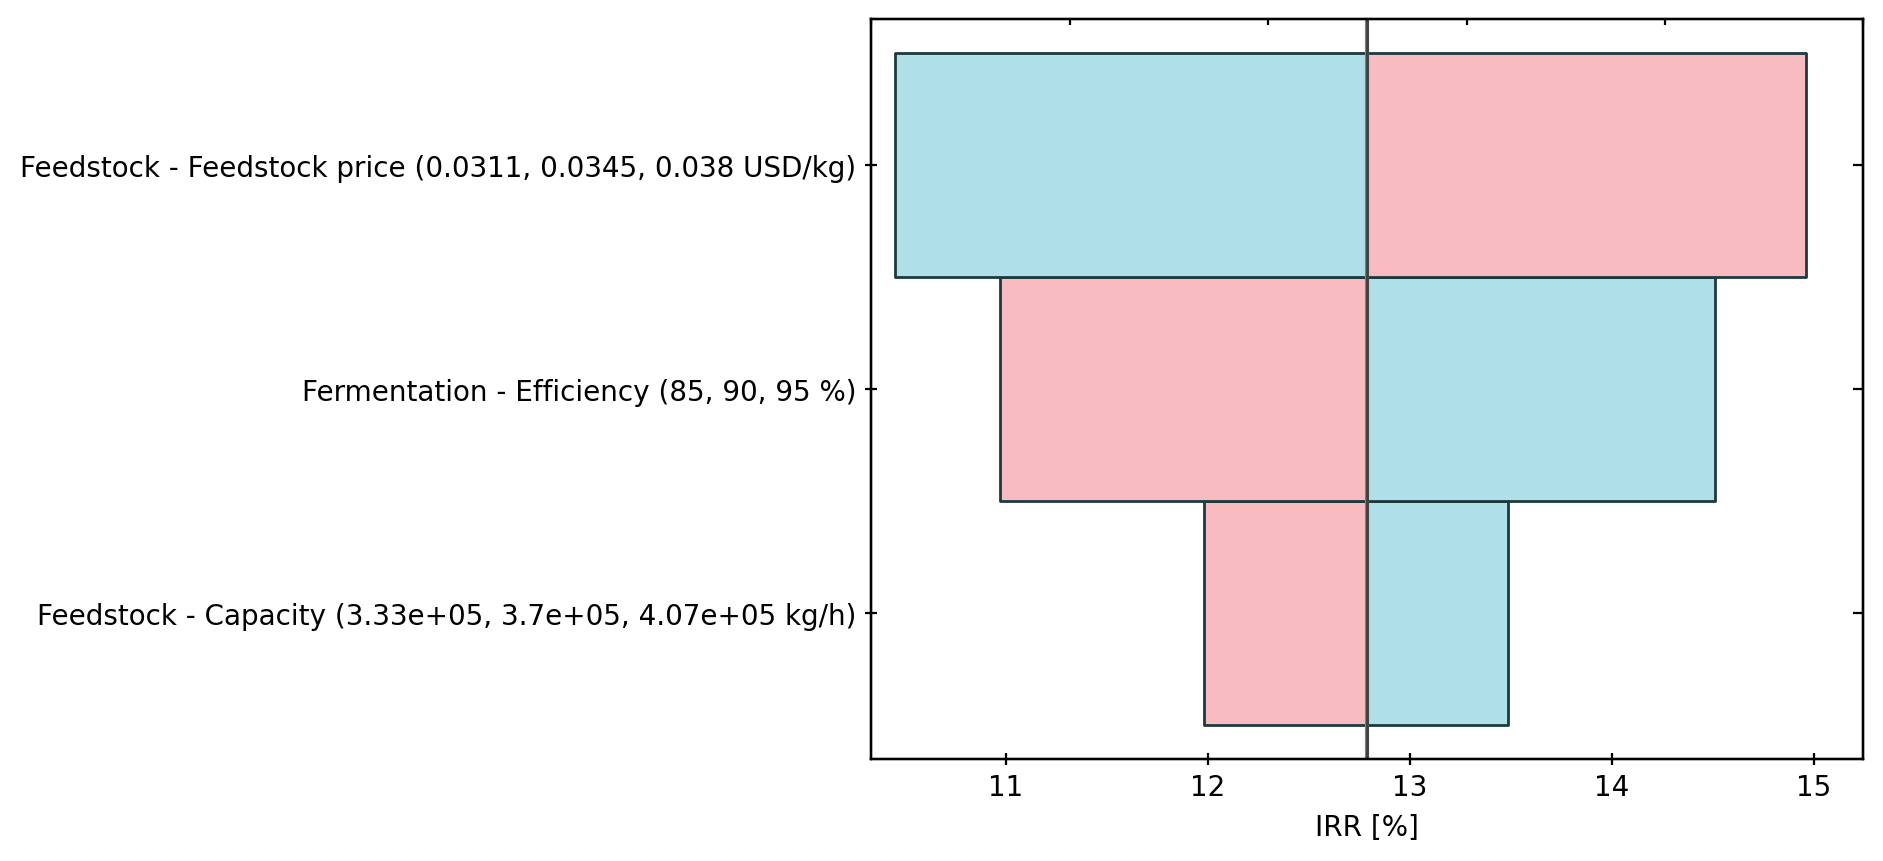

In [16]:
model = bst.Model(sugarcane_sys)

@model.parameter(
    element='feedstock', units='USD/kg', # Metadata for pretty tables/plots
    baseline=sugarcane.price, # Baseline price
    bounds=(sugarcane.price * 0.9, sugarcane.price * 1.1) # Min/max price
)
def set_feed_price(feedstock_price):
    sugarcane.price = feedstock_price

@model.parameter(
    element='feedstock', units='kg/h',
    baseline=sugarcane.F_mass,
    bounds=(sugarcane.F_mass * 0.9, sugarcane.F_mass * 1.1)
)
def set_crushing_capacity(capacity):
    sugarcane.F_mass = capacity
    
@model.parameter(
    element='fermentation', units='%',
    baseline=90, bounds=(85, 95)
)
def set_fermentation_efficiency(efficiency):
    R301.efficiency = efficiency / 100
    
@model.metric(units='%')
def IRR():
    return 100 * sugarcane_tea.solve_IRR()

baseline, lower, upper = model.single_point_sensitivity()
metric_index = IRR.index
index = [i.describe(distribution=False) # Instead of displaying distribution, it displays lower, baseline, and upper values
         for i in model.parameters]
bst.plots.plot_single_point_sensitivity(baseline[metric_index],
                                        lower[metric_index],
                                        upper[metric_index],
                                        name='IRR [%]',
                                        index=index)

The plot shows how the economic viability is most sensitive to the feedstocks price (at the given min/max ranges). Checkout the chapter on [uncertainty and sensitivity](./Uncertainty_and_sensitivity.ipynb) for more details and examples.

### References

<a id='References'></a>

1. Huang, H., Long, S. & Singh, V. Techno-economic analysis of biodiesel and ethanol co-production from lipid-producing sugarcane. Biofuels, Bioprod. Bioref. 10, 299–315 (2016).